In [53]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns

In [54]:
def f(x):
    """真实函数"""
    return 2 * torch.sin(x) + x ** 0.8


def plot_kernel_reg(y_hat):
    plt.scatter(x_train, y_train)
    plt.plot(x_test, y_truth, color='red', label='truth')
    plt.plot(x_train, y_hat, color='orange', label='pred')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

In [55]:
# 拟合数据
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)
noise = torch.normal(0, 0.25, (n_train,))  # 噪音
y_train = f(x_train) + noise

# 真实曲线
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)

基于平均汇聚来计算所有训练样本输出值的平均值:

$$ f(x)=\frac{1}{n} \sum_{i=1}^{n} y_{i} $$

In [56]:
# 使用训练样本输出值的平均值拟合曲线
y_hat = torch.repeat_interleave(y_train.mean(), len(x_test))
y_hat

tensor([2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456,
        2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456,
        2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456,
        2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456,
        2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456, 2.2456,
        2.2456, 2.2456, 2.2456, 2.2456, 2.2456])

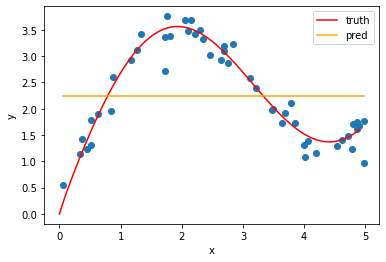

In [57]:
# 拟合效果很差
plot_kernel_reg(y_hat)

根据输⼊的位置对输出$ y_i $进⾏加权:

$$ f(x)=\sum_{i=1}^{n} \frac{K\left(x-x_{i}\right)}{\sum_{j=1}^{n} K\left(x-x_{j}\right)} y_{i}$$

其中$K$为核函数

可以从注意力机制的⻆度重写上式,成为⼀个更加通用的注意⼒汇聚(attention pooling)公式:

$$ f(x)=\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i} $$

其中$x$是查询,$(x_i, y_i)$是键值对.注意⼒汇聚是$y_i$的加权平均.将查询$x$和键$x_i$之间的关系建模为注意力
权重(attetnion weight)$\alpha(x; x_i)$,如上式所示,这个权重将被分配给每⼀个对应值$y_i$.
对于任何查询,模型在所有键值对上的注意⼒权重都是⼀个有效的概率分布:它们是⾮负数的,并且总和为1.

下面考虑核函数为高斯核(Gaussian kernel),其定义为:

$$ K(u)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{u^{2}}{2}\right) $$

代入上式,即

\begin{aligned}
f(x) &=\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i} \\
&=\sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2}\left(x-x_{i}\right)^{2}\right)}{\sum_{j=1}^{n} \exp \left(-\frac{1}{2}\left(x-x_{j}\right)^{2}\right)} y_{i} \\
&=\sum_{i=1}^{n} \operatorname{softmax}\left(-\frac{1}{2}\left(x-x_{i}\right)^{2}\right) y_{i}
\end{aligned}

由上式可知,如果⼀个键$x_i$越是接近给定的查询$x$,那么分配给这个键对应值$y_i$的注意⼒权重就会越⼤,也就是"获得了更多的注意⼒".

tensor([[0.0540, 0.0540, 0.0540,  ..., 0.0540, 0.0540, 0.0540],
        [0.3313, 0.3313, 0.3313,  ..., 0.3313, 0.3313, 0.3313],
        [0.3645, 0.3645, 0.3645,  ..., 0.3645, 0.3645, 0.3645],
        ...,
        [4.8950, 4.8950, 4.8950,  ..., 4.8950, 4.8950, 4.8950],
        [4.9729, 4.9729, 4.9729,  ..., 4.9729, 4.9729, 4.9729],
        [4.9738, 4.9738, 4.9738,  ..., 4.9738, 4.9738, 4.9738]])


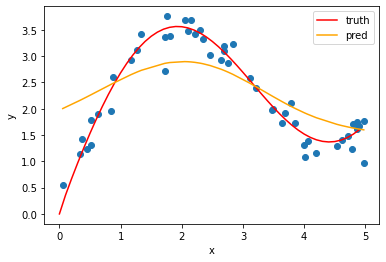

In [58]:
# 每行元素相同;X_repeat.shape(n_train, n_trian)
X_repeat = torch.unsqueeze(x_train, 1).repeat(1, n_train)
print(X_repeat)
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)  # 广播机制
y_hat = torch.matmul(attention_weights, y_train)

# 拟合效果更进一步
plot_kernel_reg(y_hat)


Text(33.0, 0.5, 'Sorted testing inputs')

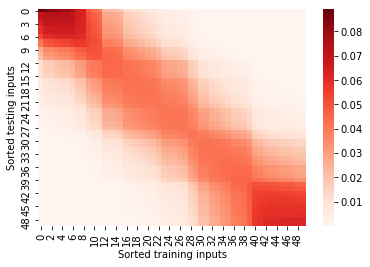

In [59]:
# 观察可知"查询-键"对越接近,注意力汇聚的注意力权重就越高
_, axes = plt.subplots(1, 1)
sns.heatmap(attention_weights, cmap='Reds', ax=axes)
axes.set_xlabel('Sorted training inputs')
axes.set_ylabel('Sorted testing inputs')

下⾯的查询$ x $和键$x_i $之间的距离乘以可学习参数$w$:

\begin{aligned}
f(x) &=\sum_{i=1}^{n} \alpha\left(x, x_{i}\right) y_{i} \\
&=\sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2}\left(\left(x-x_{i}\right) w\right)^{2}\right)}{\sum_{j=1}^{n} \exp \left(-\frac{1}{2}\left(\left(x-x_{i}\right) w\right)^{2}\right)} y_{i} \\
&=\sum_{i=1}^{n} \operatorname{softmax}\left(-\frac{1}{2}\left(\left(x-x_{i}\right) w\right)^{2}\right) y_{i}
\end{aligned}

In [60]:
class NWKernelRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # 学习参数w
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # 每一行元素值相同
        queries = torch.unsqueeze(queries, 1).repeat(1, keys.shape[1])
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w) ** 2 / 2, dim=1)
        print(self.attention_weights.unsqueeze(1).shape, values.unsqueeze(-1).shape)  # 使之可以进行矩阵乘法
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [61]:
# X_tile.shape(n_train, n_train),每列元素相同
X_tile = x_train.repeat((n_train, 1))
# Y_tile.shape=(n_train, n_train),每列元素相同
Y_tile = y_train.repeat((n_train, 1))
# keys.shape=(n_train, n_train-1)
keys = X_tile[(1 - torch.eye(n_train)).to(dtype=torch.bool)].reshape((n_train, -1))  # 去除对角线处的元素(softmax计算时对角线元素相减为0)
# values.shape=(n_train, n_train-1)
values = Y_tile[(1 - torch.eye(n_train)).to(dtype=torch.bool)].reshape((n_train, -1))

In [62]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
for epoch in range(50):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    if epoch % 10 == 0:
        print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')

torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 1, loss 20.544386
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
epoch 11, loss 2.146020
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 49, 1])
torch.Size([50, 1, 49]) torch.Size([50, 

torch.Size([50, 1, 50]) torch.Size([50, 50, 1])


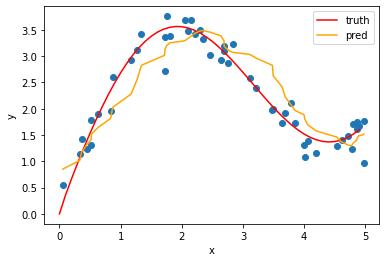

In [63]:
keys = x_train.repeat((50, 1))
values = y_train.repeat((50, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()

# 基本拟合ok
plot_kernel_reg(y_hat)

Text(33.0, 0.5, 'Sorted testing inputs')

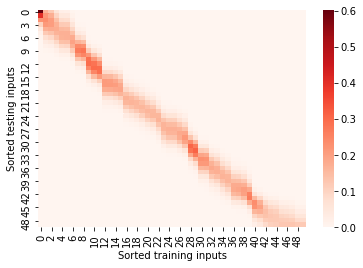

In [64]:
_, axes = plt.subplots(1, 1)
sns.heatmap(net.attention_weights.detach(), cmap='Reds', ax=axes)
axes.set_xlabel('Sorted training inputs')
axes.set_ylabel('Sorted testing inputs')


